In [13]:
import os
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Criar pasta para armazenar os dados
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

#metric_name = "CPU Usage"
#metric_name = "RAM Usage"
metric_name = "Network Usage"

if metric_name == "CPU Usage":
    dataset_path = "Server_1_Training_Sets/datasets/cpu_usage_1-13.xlsx"
elif metric_name == "RAM Usage":
    dataset_path = "Server_1_Training_Sets/datasets/ram_usage_1-13.xlsx"
elif metric_name == "Network Usage":
    dataset_path = "Server_1_Training_Sets/datasets/network_usage_1-13.xlsx"

# Carregar o dataset
dataset = pd.read_excel(dataset_path)

# Preparar os dados
X_columns = dataset.columns[:len(dataset.columns)-1]  # Colunas X1 a X40
X = dataset[X_columns].values.astype(np.float32)  # Convertendo para float32
y = dataset["y"].values.reshape(-1, 1).astype(np.float32)  # Convertendo para float32

# Ajustar os dados para o formato esperado pela LSTM
# A LSTM espera o formato (batch_size, seq_length, input_size), onde seq_length=1 neste caso
X = X.reshape(-1, 1, X.shape[1])  # Adicionando dimensão para seq_length=1

# Dividir os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2025, shuffle=True)

# Salvar os dados em disco
train_data = {"X": X_train.tolist(), "y": y_train.tolist()}
val_data = {"X": X_val.tolist(), "y": y_val.tolist()}

torch.save(train_data, os.path.join(data_dir, "train_data.pt"))
torch.save(val_data, os.path.join(data_dir, "val_data.pt"))

print(f"Dados de treinamento e validação salvos em {data_dir}.")

# Criar uma classe customizada para o dataset
class CustomDataset(Dataset):
    def __init__(self, data_path):
        data = torch.load(data_path)
        self.X = torch.tensor(data["X"], dtype=torch.float32)
        self.y = torch.tensor(data["y"], dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Carregar os dados com DataLoader
train_dataset = CustomDataset(os.path.join(data_dir, "train_data.pt"))
val_dataset = CustomDataset(os.path.join(data_dir, "val_data.pt"))

train_loader = DataLoader(train_dataset, batch_size=10240, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10240, shuffle=True)

# Verificações para checar alinhamento

# Ajuste na precisão do dataset original para float32
dataset_float32 = dataset.copy()
for col in dataset.columns:
    dataset_float32[col] = dataset[col].astype(np.float32)

# Checagem do train test split
split_dataset_sample = list(X_train[0].flatten()) + list(y_train[0])

# Checagem do CustomDataset
custom_dataset_sample = list(train_dataset.__getitem__(0)[0].numpy().flatten()) + list(train_dataset.__getitem__(0)[1].numpy())

# Checagem do DataLoader
dataloader_sample = next(iter(train_loader))
dataloader_sample = dataloader_sample[0][0].numpy().flatten().tolist() + dataloader_sample[1][0].numpy().tolist()

# Validando alinhamento
assert len(dataset_float32[(dataset_float32[dataset_float32.columns] == split_dataset_sample).all(axis=1)].index) >= 1, "Train-test split desalinhado"
assert len(dataset_float32[(dataset_float32[dataset_float32.columns] == custom_dataset_sample).all(axis=1)].index) >= 1, "CustomDataset desalinhado"
assert len(dataset_float32[(dataset_float32[dataset_float32.columns] == dataloader_sample).all(axis=1)].index) >= 1, "DataLoader desalinhado"

print("Verificações concluídas. Todos os dados estão alinhados.")

Dados de treinamento e validação salvos em ./data.
Verificações concluídas. Todos os dados estão alinhados.


/tmp/ipykernel_39273/1311228147.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


In [14]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import os
import torch.nn as nn

class ImprovedLSTM(nn.Module):
    def __init__(self):
        super(ImprovedLSTM, self).__init__()
        
        self.hidden_size = 256
        self.num_layers = 3
        self.input_size = 10
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True
        )
        
        # Layer Normalization for LSTM output
        self.layer_norm_lstm = nn.LayerNorm(2 * self.hidden_size)  # Bidirectional LSTM output size
        
        # Fully connected layers
        self.fc1 = nn.Linear(2 * self.hidden_size, 256)
        self.layer_norm_fc1 = nn.LayerNorm(256)  # LayerNorm for fc1
        
        self.fc2 = nn.Linear(256, 128)
        self.layer_norm_fc2 = nn.LayerNorm(128)  # LayerNorm for fc2
        
        self.fc3 = nn.Linear(128, 64)
        self.layer_norm_fc3 = nn.LayerNorm(64)  # LayerNorm for fc3
        
        self.fc4 = nn.Linear(64, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Pass through LSTM
        lstm_output, _ = self.lstm(x)  # lstm_output: (batch_size, seq_length, 2 * hidden_size)
        
        # Take the output of the last time step
        lstm_output = lstm_output[:, -1, :]  # (batch_size, 2 * hidden_size)
        
        # Apply Layer Normalization to LSTM output
        lstm_output = self.layer_norm_lstm(lstm_output)
        
        # Fully connected layers with Layer Normalization, activation, and dropout
        x = self.fc1(lstm_output)
        x = self.layer_norm_fc1(x)  # LayerNorm for fc1
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.layer_norm_fc2(x)  # LayerNorm for fc2
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.layer_norm_fc3(x)  # LayerNorm for fc3
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        
        # Output layer
        out = self.sigmoid(x)  # Assuming binary classification or scaled output
        
        return out

In [15]:
from tqdm import tqdm

if not os.path.exists('models'):
    os.makedirs('models')

model = ImprovedLSTM()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
n_epochs = 1000
max_consecutive_increases = 10

best_rmse = float('inf')
best_epoch = 0
consecutive_increases = 0

train_rmse_history = []
val_rmse_history = []

for epoch in range(n_epochs):
    # -------------------------------------- TRAINING ----------------------------------------------
    
    model.train()  # Certifique-se de que o modelo está em modo de treinamento
    train_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)  # Acumula a loss total ponderada pelo tamanho do batch
    
    # Calcular RMSE de treino médio para a época
    train_rmse = np.sqrt(train_loss / len(train_loader.dataset))

    # -------------------------------------- VALIDATION --------------------------------------------

    # Avaliação no conjunto de validação
    val_loss = 0.0
    with torch.no_grad():  # Desabilita o cálculo de gradientes
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)  # Acumula a loss total ponderada pelo tamanho do batch
    
    # Calcular RMSE de validação médio para a época
    val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
    
    # Salvar histórico de RMSE
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)
    
    # Printar os resultados da época
    print(f"Epoch {epoch+1}/{n_epochs}: train RMSE {train_rmse:.4f}, val RMSE {val_rmse:.4f}")
    

    # -------------------------------------- CHECKPOINTING -----------------------------------------
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_epoch = epoch
        checkpoint_path = f"models/model_best_rmse.pt"
        torch.save(model, checkpoint_path)
        print(f"Modelo salvo com RMSE (BEST): {best_rmse} na época {epoch}")
    
    with open("models/performance.txt", "w") as f:
        f.write(f"Best Model Val RMSE: {best_rmse}\nModel Best Val Epoch: {best_epoch}\nModel Train RMSE History: {train_rmse_history}\nModel Val RMSE History: {val_rmse_history}")

    if len(val_rmse_history) > 1 and val_rmse > val_rmse_history[-2]:
        consecutive_increases += 1
    else:
        consecutive_increases = 0
    
    if consecutive_increases >= max_consecutive_increases:
        print(f"Early stopping at epoch {epoch} due to consecutive increases in RMSE.")
        break

print(f"Melhor RMSE encontrado: {best_rmse} na época {best_epoch}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


Epoch 1/1000: train RMSE 0.3019, val RMSE 0.0910
Modelo salvo com RMSE (BEST): 0.09101773411022043 na época 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


Epoch 2/1000: train RMSE 0.0870, val RMSE 0.0789
Modelo salvo com RMSE (BEST): 0.07890448037136596 na época 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch 3/1000: train RMSE 0.0803, val RMSE 0.0835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]

Epoch 4/1000: train RMSE 0.0841, val RMSE 0.0863



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]


Epoch 5/1000: train RMSE 0.0853, val RMSE 0.0840


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.57it/s]


Epoch 6/1000: train RMSE 0.0839, val RMSE 0.0812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


Epoch 7/1000: train RMSE 0.0811, val RMSE 0.0801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.68it/s]


Epoch 8/1000: train RMSE 0.0784, val RMSE 0.0771
Modelo salvo com RMSE (BEST): 0.07713061742557972 na época 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.07it/s]


Epoch 9/1000: train RMSE 0.0766, val RMSE 0.0754
Modelo salvo com RMSE (BEST): 0.07544058579764286 na época 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.15it/s]


Epoch 10/1000: train RMSE 0.0761, val RMSE 0.0756


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


Epoch 11/1000: train RMSE 0.0764, val RMSE 0.0753
Modelo salvo com RMSE (BEST): 0.07527332160893276 na época 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]


Epoch 12/1000: train RMSE 0.0760, val RMSE 0.0760


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


Epoch 13/1000: train RMSE 0.0752, val RMSE 0.0754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]


Epoch 14/1000: train RMSE 0.0750, val RMSE 0.0737
Modelo salvo com RMSE (BEST): 0.07368747771483611 na época 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


Epoch 15/1000: train RMSE 0.0740, val RMSE 0.0742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 16/1000: train RMSE 0.0737, val RMSE 0.0734
Modelo salvo com RMSE (BEST): 0.07343873038174324 na época 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.50it/s]


Epoch 17/1000: train RMSE 0.0728, val RMSE 0.0753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 18/1000: train RMSE 0.0728, val RMSE 0.0716
Modelo salvo com RMSE (BEST): 0.07155291835698262 na época 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.66it/s]


Epoch 19/1000: train RMSE 0.0725, val RMSE 0.0737


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch 20/1000: train RMSE 0.0723, val RMSE 0.0744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.62it/s]


Epoch 21/1000: train RMSE 0.0723, val RMSE 0.0709
Modelo salvo com RMSE (BEST): 0.07088722345239035 na época 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.08it/s]


Epoch 22/1000: train RMSE 0.0720, val RMSE 0.0722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 23/1000: train RMSE 0.0715, val RMSE 0.0715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


Epoch 24/1000: train RMSE 0.0717, val RMSE 0.0710


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]


Epoch 25/1000: train RMSE 0.0714, val RMSE 0.0699
Modelo salvo com RMSE (BEST): 0.06994356279902034 na época 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


Epoch 26/1000: train RMSE 0.0710, val RMSE 0.0697
Modelo salvo com RMSE (BEST): 0.06971047547099748 na época 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.57it/s]


Epoch 27/1000: train RMSE 0.0711, val RMSE 0.0705


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 28/1000: train RMSE 0.0704, val RMSE 0.0703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.28it/s]


Epoch 29/1000: train RMSE 0.0703, val RMSE 0.0701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


Epoch 30/1000: train RMSE 0.0702, val RMSE 0.0701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]

Epoch 31/1000: train RMSE 0.0705, val RMSE 0.0715



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


Epoch 32/1000: train RMSE 0.0706, val RMSE 0.0700


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]


Epoch 33/1000: train RMSE 0.0700, val RMSE 0.0695
Modelo salvo com RMSE (BEST): 0.06946697411882037 na época 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.16it/s]


Epoch 34/1000: train RMSE 0.0698, val RMSE 0.0697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.92it/s]


Epoch 35/1000: train RMSE 0.0696, val RMSE 0.0707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]


Epoch 36/1000: train RMSE 0.0698, val RMSE 0.0707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.77it/s]


Epoch 37/1000: train RMSE 0.0697, val RMSE 0.0699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 38/1000: train RMSE 0.0695, val RMSE 0.0694
Modelo salvo com RMSE (BEST): 0.06944312286443968 na época 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


Epoch 39/1000: train RMSE 0.0694, val RMSE 0.0686
Modelo salvo com RMSE (BEST): 0.06858823816555902 na época 38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.07it/s]


Epoch 40/1000: train RMSE 0.0688, val RMSE 0.0711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch 41/1000: train RMSE 0.0695, val RMSE 0.0686
Modelo salvo com RMSE (BEST): 0.06856159205322361 na época 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]


Epoch 42/1000: train RMSE 0.0692, val RMSE 0.0676
Modelo salvo com RMSE (BEST): 0.06757442899750989 na época 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


Epoch 43/1000: train RMSE 0.0697, val RMSE 0.0692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.31it/s]


Epoch 44/1000: train RMSE 0.0688, val RMSE 0.0682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


Epoch 45/1000: train RMSE 0.0691, val RMSE 0.0687


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.57it/s]


Epoch 46/1000: train RMSE 0.0694, val RMSE 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 47/1000: train RMSE 0.0688, val RMSE 0.0683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.09it/s]


Epoch 48/1000: train RMSE 0.0683, val RMSE 0.0699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


Epoch 49/1000: train RMSE 0.0689, val RMSE 0.0675
Modelo salvo com RMSE (BEST): 0.06750417919378583 na época 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]


Epoch 50/1000: train RMSE 0.0686, val RMSE 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.99it/s]


Epoch 51/1000: train RMSE 0.0686, val RMSE 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


Epoch 52/1000: train RMSE 0.0687, val RMSE 0.0690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 53/1000: train RMSE 0.0687, val RMSE 0.0684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 54/1000: train RMSE 0.0685, val RMSE 0.0687


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.46it/s]


Epoch 55/1000: train RMSE 0.0688, val RMSE 0.0690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]


Epoch 56/1000: train RMSE 0.0686, val RMSE 0.0683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 57/1000: train RMSE 0.0686, val RMSE 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 58/1000: train RMSE 0.0685, val RMSE 0.0683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 59/1000: train RMSE 0.0686, val RMSE 0.0697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 60/1000: train RMSE 0.0681, val RMSE 0.0690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 61/1000: train RMSE 0.0685, val RMSE 0.0686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.20it/s]


Epoch 62/1000: train RMSE 0.0686, val RMSE 0.0676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 63/1000: train RMSE 0.0682, val RMSE 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 64/1000: train RMSE 0.0681, val RMSE 0.0697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]


Epoch 65/1000: train RMSE 0.0683, val RMSE 0.0689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 66/1000: train RMSE 0.0680, val RMSE 0.0683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]


Epoch 67/1000: train RMSE 0.0683, val RMSE 0.0682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 68/1000: train RMSE 0.0687, val RMSE 0.0677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]


Epoch 69/1000: train RMSE 0.0680, val RMSE 0.0682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 70/1000: train RMSE 0.0684, val RMSE 0.0681


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 71/1000: train RMSE 0.0682, val RMSE 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 72/1000: train RMSE 0.0679, val RMSE 0.0682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]


Epoch 73/1000: train RMSE 0.0679, val RMSE 0.0684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 74/1000: train RMSE 0.0679, val RMSE 0.0675
Modelo salvo com RMSE (BEST): 0.06746535152579719 na época 73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


Epoch 75/1000: train RMSE 0.0675, val RMSE 0.0678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


Epoch 76/1000: train RMSE 0.0676, val RMSE 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 77/1000: train RMSE 0.0680, val RMSE 0.0680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 78/1000: train RMSE 0.0679, val RMSE 0.0686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]


Epoch 79/1000: train RMSE 0.0679, val RMSE 0.0686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 80/1000: train RMSE 0.0676, val RMSE 0.0695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 81/1000: train RMSE 0.0680, val RMSE 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


Epoch 82/1000: train RMSE 0.0678, val RMSE 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]


Epoch 83/1000: train RMSE 0.0676, val RMSE 0.0677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


Epoch 84/1000: train RMSE 0.0675, val RMSE 0.0682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


Epoch 85/1000: train RMSE 0.0676, val RMSE 0.0677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 86/1000: train RMSE 0.0680, val RMSE 0.0676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 87/1000: train RMSE 0.0678, val RMSE 0.0668
Modelo salvo com RMSE (BEST): 0.06683965854887758 na época 86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 88/1000: train RMSE 0.0673, val RMSE 0.0682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 89/1000: train RMSE 0.0674, val RMSE 0.0673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.21it/s]


Epoch 90/1000: train RMSE 0.0675, val RMSE 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 91/1000: train RMSE 0.0678, val RMSE 0.0672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.41it/s]


Epoch 92/1000: train RMSE 0.0675, val RMSE 0.0680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.34it/s]


Epoch 93/1000: train RMSE 0.0673, val RMSE 0.0666
Modelo salvo com RMSE (BEST): 0.06658897784411859 na época 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.14it/s]


Epoch 94/1000: train RMSE 0.0679, val RMSE 0.0674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.46it/s]


Epoch 95/1000: train RMSE 0.0676, val RMSE 0.0671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.52it/s]


Epoch 96/1000: train RMSE 0.0675, val RMSE 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Epoch 97/1000: train RMSE 0.0676, val RMSE 0.0674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]


Epoch 98/1000: train RMSE 0.0675, val RMSE 0.0683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.77it/s]


Epoch 99/1000: train RMSE 0.0680, val RMSE 0.0674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.42it/s]


Epoch 100/1000: train RMSE 0.0671, val RMSE 0.0664
Modelo salvo com RMSE (BEST): 0.06642703123859789 na época 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]


Epoch 101/1000: train RMSE 0.0670, val RMSE 0.0677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]


Epoch 102/1000: train RMSE 0.0676, val RMSE 0.0684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch 103/1000: train RMSE 0.0673, val RMSE 0.0672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.12it/s]


Epoch 104/1000: train RMSE 0.0674, val RMSE 0.0673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch 105/1000: train RMSE 0.0669, val RMSE 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.50it/s]


Epoch 106/1000: train RMSE 0.0674, val RMSE 0.0678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 107/1000: train RMSE 0.0674, val RMSE 0.0680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


Epoch 108/1000: train RMSE 0.0667, val RMSE 0.0672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 109/1000: train RMSE 0.0668, val RMSE 0.0673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]


Epoch 110/1000: train RMSE 0.0667, val RMSE 0.0664
Modelo salvo com RMSE (BEST): 0.06639678971839937 na época 109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.52it/s]


Epoch 111/1000: train RMSE 0.0660, val RMSE 0.0646
Modelo salvo com RMSE (BEST): 0.06460157911854267 na época 110


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 112/1000: train RMSE 0.0653, val RMSE 0.0649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 113/1000: train RMSE 0.0649, val RMSE 0.0632
Modelo salvo com RMSE (BEST): 0.06317649488942918 na época 112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]


Epoch 114/1000: train RMSE 0.0633, val RMSE 0.0621
Modelo salvo com RMSE (BEST): 0.062124564529697404 na época 113


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.79it/s]


Epoch 115/1000: train RMSE 0.0613, val RMSE 0.0588
Modelo salvo com RMSE (BEST): 0.05875395886419038 na época 114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.60it/s]


Epoch 116/1000: train RMSE 0.0576, val RMSE 0.0598


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]


Epoch 117/1000: train RMSE 0.0631, val RMSE 0.0524
Modelo salvo com RMSE (BEST): 0.05236580983452167 na época 116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


Epoch 118/1000: train RMSE 0.0520, val RMSE 0.0677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.76it/s]


Epoch 119/1000: train RMSE 0.0602, val RMSE 0.0619


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]


Epoch 120/1000: train RMSE 0.0587, val RMSE 0.0450
Modelo salvo com RMSE (BEST): 0.04504251607059213 na época 119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.66it/s]


Epoch 121/1000: train RMSE 0.0500, val RMSE 0.0460


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


Epoch 122/1000: train RMSE 0.0463, val RMSE 0.0478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.15it/s]


Epoch 123/1000: train RMSE 0.0463, val RMSE 0.0413
Modelo salvo com RMSE (BEST): 0.041330401208279154 na época 122


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.32it/s]


Epoch 124/1000: train RMSE 0.0431, val RMSE 0.0433


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]


Epoch 125/1000: train RMSE 0.0441, val RMSE 0.0396
Modelo salvo com RMSE (BEST): 0.039649136130750155 na época 124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.24it/s]


Epoch 126/1000: train RMSE 0.0396, val RMSE 0.0392
Modelo salvo com RMSE (BEST): 0.03916004934795752 na época 125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.47it/s]


Epoch 127/1000: train RMSE 0.0393, val RMSE 0.0426


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 128/1000: train RMSE 0.0433, val RMSE 0.0411


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]


Epoch 129/1000: train RMSE 0.0405, val RMSE 0.0377
Modelo salvo com RMSE (BEST): 0.03770649934217855 na época 128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 130/1000: train RMSE 0.0392, val RMSE 0.0398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.57it/s]


Epoch 131/1000: train RMSE 0.0390, val RMSE 0.0359
Modelo salvo com RMSE (BEST): 0.03585608293759713 na época 130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.46it/s]


Epoch 132/1000: train RMSE 0.0381, val RMSE 0.0371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]


Epoch 133/1000: train RMSE 0.0380, val RMSE 0.0351
Modelo salvo com RMSE (BEST): 0.03507381450160112 na época 132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.75it/s]


Epoch 134/1000: train RMSE 0.0369, val RMSE 0.0358


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


Epoch 135/1000: train RMSE 0.0370, val RMSE 0.0351
Modelo salvo com RMSE (BEST): 0.035050682341409393 na época 134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.74it/s]


Epoch 136/1000: train RMSE 0.0367, val RMSE 0.0350
Modelo salvo com RMSE (BEST): 0.0349709458517148 na época 135


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]


Epoch 137/1000: train RMSE 0.0363, val RMSE 0.0343
Modelo salvo com RMSE (BEST): 0.034328424873591945 na época 136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


Epoch 138/1000: train RMSE 0.0353, val RMSE 0.0363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]


Epoch 139/1000: train RMSE 0.0358, val RMSE 0.0349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 140/1000: train RMSE 0.0357, val RMSE 0.0330
Modelo salvo com RMSE (BEST): 0.03296191944193133 na época 139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]


Epoch 141/1000: train RMSE 0.0353, val RMSE 0.0353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch 142/1000: train RMSE 0.0365, val RMSE 0.0358


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]


Epoch 143/1000: train RMSE 0.0352, val RMSE 0.0349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 144/1000: train RMSE 0.0349, val RMSE 0.0339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]


Epoch 145/1000: train RMSE 0.0347, val RMSE 0.0331


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 146/1000: train RMSE 0.0346, val RMSE 0.0342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 147/1000: train RMSE 0.0352, val RMSE 0.0327
Modelo salvo com RMSE (BEST): 0.03271353953879059 na época 146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.32it/s]


Epoch 148/1000: train RMSE 0.0345, val RMSE 0.0351


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 149/1000: train RMSE 0.0356, val RMSE 0.0327
Modelo salvo com RMSE (BEST): 0.03267262887940111 na época 148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]


Epoch 150/1000: train RMSE 0.0344, val RMSE 0.0353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 151/1000: train RMSE 0.0355, val RMSE 0.0331


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


Epoch 152/1000: train RMSE 0.0340, val RMSE 0.0345


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 153/1000: train RMSE 0.0346, val RMSE 0.0329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 154/1000: train RMSE 0.0339, val RMSE 0.0331


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 155/1000: train RMSE 0.0339, val RMSE 0.0337


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.28it/s]


Epoch 156/1000: train RMSE 0.0336, val RMSE 0.0343


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch 157/1000: train RMSE 0.0341, val RMSE 0.0319
Modelo salvo com RMSE (BEST): 0.03185562668766464 na época 156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.09it/s]


Epoch 158/1000: train RMSE 0.0334, val RMSE 0.0329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


Epoch 159/1000: train RMSE 0.0331, val RMSE 0.0336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]


Epoch 160/1000: train RMSE 0.0330, val RMSE 0.0321


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 161/1000: train RMSE 0.0332, val RMSE 0.0316
Modelo salvo com RMSE (BEST): 0.03162177968415157 na época 160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 162/1000: train RMSE 0.0328, val RMSE 0.0327


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 163/1000: train RMSE 0.0329, val RMSE 0.0332


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]


Epoch 164/1000: train RMSE 0.0332, val RMSE 0.0318


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.21it/s]


Epoch 165/1000: train RMSE 0.0333, val RMSE 0.0322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]

Epoch 166/1000: train RMSE 0.0326, val RMSE 0.0316


Modelo salvo com RMSE (BEST): 0.03160705949459732 na época 165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.47it/s]


Epoch 167/1000: train RMSE 0.0334, val RMSE 0.0312
Modelo salvo com RMSE (BEST): 0.03121252718924483 na época 166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.03it/s]


Epoch 168/1000: train RMSE 0.0327, val RMSE 0.0344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]


Epoch 169/1000: train RMSE 0.0344, val RMSE 0.0328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


Epoch 170/1000: train RMSE 0.0344, val RMSE 0.0325


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 171/1000: train RMSE 0.0332, val RMSE 0.0332


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


Epoch 172/1000: train RMSE 0.0336, val RMSE 0.0310
Modelo salvo com RMSE (BEST): 0.03100641129971175 na época 171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.15it/s]


Epoch 173/1000: train RMSE 0.0323, val RMSE 0.0327


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


Epoch 174/1000: train RMSE 0.0329, val RMSE 0.0309
Modelo salvo com RMSE (BEST): 0.030874461058242524 na época 173


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.98it/s]


Epoch 175/1000: train RMSE 0.0320, val RMSE 0.0317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 176/1000: train RMSE 0.0326, val RMSE 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 177/1000: train RMSE 0.0319, val RMSE 0.0320


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 178/1000: train RMSE 0.0319, val RMSE 0.0308
Modelo salvo com RMSE (BEST): 0.03075807035094398 na época 177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.59it/s]


Epoch 179/1000: train RMSE 0.0321, val RMSE 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]


Epoch 180/1000: train RMSE 0.0318, val RMSE 0.0319


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 181/1000: train RMSE 0.0319, val RMSE 0.0316


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


Epoch 182/1000: train RMSE 0.0320, val RMSE 0.0319


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 183/1000: train RMSE 0.0322, val RMSE 0.0297
Modelo salvo com RMSE (BEST): 0.02970446537907562 na época 182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 184/1000: train RMSE 0.0317, val RMSE 0.0311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 185/1000: train RMSE 0.0317, val RMSE 0.0306


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]


Epoch 186/1000: train RMSE 0.0316, val RMSE 0.0304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 187/1000: train RMSE 0.0314, val RMSE 0.0309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 188/1000: train RMSE 0.0315, val RMSE 0.0313


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 189/1000: train RMSE 0.0314, val RMSE 0.0298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


Epoch 190/1000: train RMSE 0.0312, val RMSE 0.0300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]


Epoch 191/1000: train RMSE 0.0313, val RMSE 0.0309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.27it/s]


Epoch 192/1000: train RMSE 0.0312, val RMSE 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 193/1000: train RMSE 0.0312, val RMSE 0.0304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 194/1000: train RMSE 0.0309, val RMSE 0.0313


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.59it/s]


Epoch 195/1000: train RMSE 0.0311, val RMSE 0.0309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.02it/s]


Epoch 196/1000: train RMSE 0.0313, val RMSE 0.0312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 197/1000: train RMSE 0.0310, val RMSE 0.0308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 198/1000: train RMSE 0.0312, val RMSE 0.0309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 199/1000: train RMSE 0.0307, val RMSE 0.0312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


Epoch 200/1000: train RMSE 0.0309, val RMSE 0.0302


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


Epoch 201/1000: train RMSE 0.0309, val RMSE 0.0307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 202/1000: train RMSE 0.0305, val RMSE 0.0299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]


Epoch 203/1000: train RMSE 0.0309, val RMSE 0.0298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 204/1000: train RMSE 0.0308, val RMSE 0.0292
Modelo salvo com RMSE (BEST): 0.029247669781146967 na época 203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]


Epoch 205/1000: train RMSE 0.0310, val RMSE 0.0297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


Epoch 206/1000: train RMSE 0.0306, val RMSE 0.0293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 207/1000: train RMSE 0.0308, val RMSE 0.0300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 208/1000: train RMSE 0.0313, val RMSE 0.0303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]


Epoch 209/1000: train RMSE 0.0309, val RMSE 0.0311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 210/1000: train RMSE 0.0315, val RMSE 0.0300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 211/1000: train RMSE 0.0311, val RMSE 0.0305


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


Epoch 212/1000: train RMSE 0.0311, val RMSE 0.0314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 213/1000: train RMSE 0.0317, val RMSE 0.0299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


Epoch 214/1000: train RMSE 0.0309, val RMSE 0.0319


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]


Epoch 215/1000: train RMSE 0.0319, val RMSE 0.0289
Modelo salvo com RMSE (BEST): 0.028871180349523837 na época 214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 216/1000: train RMSE 0.0309, val RMSE 0.0306


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


Epoch 217/1000: train RMSE 0.0312, val RMSE 0.0293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 218/1000: train RMSE 0.0305, val RMSE 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 219/1000: train RMSE 0.0309, val RMSE 0.0297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 220/1000: train RMSE 0.0303, val RMSE 0.0304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


Epoch 221/1000: train RMSE 0.0306, val RMSE 0.0304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 222/1000: train RMSE 0.0298, val RMSE 0.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]


Epoch 223/1000: train RMSE 0.0303, val RMSE 0.0293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


Epoch 224/1000: train RMSE 0.0305, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]


Epoch 225/1000: train RMSE 0.0301, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.60it/s]


Epoch 226/1000: train RMSE 0.0300, val RMSE 0.0288
Modelo salvo com RMSE (BEST): 0.028838880225168912 na época 225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


Epoch 227/1000: train RMSE 0.0299, val RMSE 0.0299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


Epoch 228/1000: train RMSE 0.0299, val RMSE 0.0296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 229/1000: train RMSE 0.0300, val RMSE 0.0301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]


Epoch 230/1000: train RMSE 0.0307, val RMSE 0.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.59it/s]


Epoch 231/1000: train RMSE 0.0300, val RMSE 0.0282
Modelo salvo com RMSE (BEST): 0.028192685764683853 na época 230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.98it/s]


Epoch 232/1000: train RMSE 0.0299, val RMSE 0.0292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.59it/s]


Epoch 233/1000: train RMSE 0.0305, val RMSE 0.0322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.14it/s]


Epoch 234/1000: train RMSE 0.0316, val RMSE 0.0299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]


Epoch 235/1000: train RMSE 0.0308, val RMSE 0.0301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.72it/s]


Epoch 236/1000: train RMSE 0.0307, val RMSE 0.0298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.35it/s]


Epoch 237/1000: train RMSE 0.0302, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch 238/1000: train RMSE 0.0303, val RMSE 0.0295


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.91it/s]


Epoch 239/1000: train RMSE 0.0304, val RMSE 0.0298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 240/1000: train RMSE 0.0302, val RMSE 0.0306


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 241/1000: train RMSE 0.0319, val RMSE 0.0318


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 242/1000: train RMSE 0.0310, val RMSE 0.0304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.45it/s]


Epoch 243/1000: train RMSE 0.0308, val RMSE 0.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


Epoch 244/1000: train RMSE 0.0300, val RMSE 0.0297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]


Epoch 245/1000: train RMSE 0.0308, val RMSE 0.0299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 246/1000: train RMSE 0.0302, val RMSE 0.0296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]


Epoch 247/1000: train RMSE 0.0309, val RMSE 0.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


Epoch 248/1000: train RMSE 0.0299, val RMSE 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 249/1000: train RMSE 0.0301, val RMSE 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


Epoch 250/1000: train RMSE 0.0297, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.04it/s]

Epoch 251/1000: train RMSE 0.0295, val RMSE 0.0278


Modelo salvo com RMSE (BEST): 0.027838734396791333 na época 250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


Epoch 252/1000: train RMSE 0.0295, val RMSE 0.0303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]


Epoch 253/1000: train RMSE 0.0301, val RMSE 0.0297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 254/1000: train RMSE 0.0302, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.26it/s]


Epoch 255/1000: train RMSE 0.0298, val RMSE 0.0289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


Epoch 256/1000: train RMSE 0.0295, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.51it/s]


Epoch 257/1000: train RMSE 0.0296, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.36it/s]


Epoch 258/1000: train RMSE 0.0296, val RMSE 0.0287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]


Epoch 259/1000: train RMSE 0.0293, val RMSE 0.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


Epoch 260/1000: train RMSE 0.0296, val RMSE 0.0275
Modelo salvo com RMSE (BEST): 0.027469743872247883 na época 259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.50it/s]


Epoch 261/1000: train RMSE 0.0293, val RMSE 0.0289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


Epoch 262/1000: train RMSE 0.0299, val RMSE 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]


Epoch 263/1000: train RMSE 0.0296, val RMSE 0.0296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.22it/s]

Epoch 264/1000: train RMSE 0.0296, val RMSE 0.0280



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.74it/s]


Epoch 265/1000: train RMSE 0.0294, val RMSE 0.0287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.37it/s]


Epoch 266/1000: train RMSE 0.0297, val RMSE 0.0283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 267/1000: train RMSE 0.0295, val RMSE 0.0293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]


Epoch 268/1000: train RMSE 0.0298, val RMSE 0.0296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.33it/s]


Epoch 269/1000: train RMSE 0.0299, val RMSE 0.0296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.22it/s]


Epoch 270/1000: train RMSE 0.0293, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


Epoch 271/1000: train RMSE 0.0299, val RMSE 0.0292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


Epoch 272/1000: train RMSE 0.0295, val RMSE 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 273/1000: train RMSE 0.0296, val RMSE 0.0289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


Epoch 274/1000: train RMSE 0.0292, val RMSE 0.0284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]


Epoch 275/1000: train RMSE 0.0296, val RMSE 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 276/1000: train RMSE 0.0294, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 277/1000: train RMSE 0.0292, val RMSE 0.0287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

Epoch 278/1000: train RMSE 0.0290, val RMSE 0.0274


Modelo salvo com RMSE (BEST): 0.02737025483488413 na época 277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.01it/s]


Epoch 279/1000: train RMSE 0.0291, val RMSE 0.0283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.08it/s]


Epoch 280/1000: train RMSE 0.0293, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.37it/s]


Epoch 281/1000: train RMSE 0.0293, val RMSE 0.0283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


Epoch 282/1000: train RMSE 0.0292, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.89it/s]


Epoch 283/1000: train RMSE 0.0294, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 284/1000: train RMSE 0.0292, val RMSE 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 285/1000: train RMSE 0.0294, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.38it/s]


Epoch 286/1000: train RMSE 0.0293, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.18it/s]


Epoch 287/1000: train RMSE 0.0287, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.75it/s]


Epoch 288/1000: train RMSE 0.0293, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]


Epoch 289/1000: train RMSE 0.0292, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 290/1000: train RMSE 0.0295, val RMSE 0.0274
Modelo salvo com RMSE (BEST): 0.027365681036234223 na época 289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.45it/s]


Epoch 291/1000: train RMSE 0.0291, val RMSE 0.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


Epoch 292/1000: train RMSE 0.0297, val RMSE 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

Epoch 293/1000: train RMSE 0.0292, val RMSE 0.0270


Modelo salvo com RMSE (BEST): 0.02697539536775093 na época 292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]


Epoch 294/1000: train RMSE 0.0295, val RMSE 0.0298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.48it/s]


Epoch 295/1000: train RMSE 0.0296, val RMSE 0.0292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]


Epoch 296/1000: train RMSE 0.0289, val RMSE 0.0293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 297/1000: train RMSE 0.0295, val RMSE 0.0287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


Epoch 298/1000: train RMSE 0.0291, val RMSE 0.0289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 299/1000: train RMSE 0.0297, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]


Epoch 300/1000: train RMSE 0.0294, val RMSE 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


Epoch 301/1000: train RMSE 0.0289, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 302/1000: train RMSE 0.0299, val RMSE 0.0292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


Epoch 303/1000: train RMSE 0.0299, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]


Epoch 304/1000: train RMSE 0.0291, val RMSE 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


Epoch 305/1000: train RMSE 0.0301, val RMSE 0.0286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.01it/s]


Epoch 306/1000: train RMSE 0.0291, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch 307/1000: train RMSE 0.0294, val RMSE 0.0294


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


Epoch 308/1000: train RMSE 0.0293, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.74it/s]


Epoch 309/1000: train RMSE 0.0291, val RMSE 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]


Epoch 310/1000: train RMSE 0.0290, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]


Epoch 311/1000: train RMSE 0.0288, val RMSE 0.0286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 312/1000: train RMSE 0.0290, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 313/1000: train RMSE 0.0293, val RMSE 0.0293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


Epoch 314/1000: train RMSE 0.0299, val RMSE 0.0284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]


Epoch 315/1000: train RMSE 0.0291, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


Epoch 316/1000: train RMSE 0.0290, val RMSE 0.0287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.22it/s]


Epoch 317/1000: train RMSE 0.0290, val RMSE 0.0283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 318/1000: train RMSE 0.0288, val RMSE 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]


Epoch 319/1000: train RMSE 0.0291, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 320/1000: train RMSE 0.0289, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.22it/s]


Epoch 321/1000: train RMSE 0.0290, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 322/1000: train RMSE 0.0291, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.80it/s]


Epoch 323/1000: train RMSE 0.0290, val RMSE 0.0289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.72it/s]


Epoch 324/1000: train RMSE 0.0300, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]


Epoch 325/1000: train RMSE 0.0294, val RMSE 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.14it/s]


Epoch 326/1000: train RMSE 0.0295, val RMSE 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.89it/s]


Epoch 327/1000: train RMSE 0.0288, val RMSE 0.0279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.40it/s]


Epoch 328/1000: train RMSE 0.0287, val RMSE 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.65it/s]


Epoch 329/1000: train RMSE 0.0288, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]


Epoch 330/1000: train RMSE 0.0287, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


Epoch 331/1000: train RMSE 0.0282, val RMSE 0.0284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]


Epoch 332/1000: train RMSE 0.0287, val RMSE 0.0284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


Epoch 333/1000: train RMSE 0.0286, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.37it/s]


Epoch 334/1000: train RMSE 0.0286, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


Epoch 335/1000: train RMSE 0.0284, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.73it/s]


Epoch 336/1000: train RMSE 0.0288, val RMSE 0.0284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.03it/s]


Epoch 337/1000: train RMSE 0.0288, val RMSE 0.0293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]


Epoch 338/1000: train RMSE 0.0285, val RMSE 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 339/1000: train RMSE 0.0288, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]


Epoch 340/1000: train RMSE 0.0285, val RMSE 0.0278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 341/1000: train RMSE 0.0286, val RMSE 0.0286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]


Epoch 342/1000: train RMSE 0.0291, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.98it/s]


Epoch 343/1000: train RMSE 0.0285, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]


Epoch 344/1000: train RMSE 0.0288, val RMSE 0.0292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 345/1000: train RMSE 0.0293, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.18it/s]


Epoch 346/1000: train RMSE 0.0292, val RMSE 0.0299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]


Epoch 347/1000: train RMSE 0.0293, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]


Epoch 348/1000: train RMSE 0.0288, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Epoch 349/1000: train RMSE 0.0285, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]


Epoch 350/1000: train RMSE 0.0285, val RMSE 0.0283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch 351/1000: train RMSE 0.0287, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]


Epoch 352/1000: train RMSE 0.0286, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


Epoch 353/1000: train RMSE 0.0281, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.52it/s]


Epoch 354/1000: train RMSE 0.0283, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 355/1000: train RMSE 0.0283, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


Epoch 356/1000: train RMSE 0.0284, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.28it/s]


Epoch 357/1000: train RMSE 0.0285, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.53it/s]


Epoch 358/1000: train RMSE 0.0289, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.16it/s]


Epoch 359/1000: train RMSE 0.0285, val RMSE 0.0278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]


Epoch 360/1000: train RMSE 0.0287, val RMSE 0.0269
Modelo salvo com RMSE (BEST): 0.026866745748545987 na época 359


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 361/1000: train RMSE 0.0285, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]


Epoch 362/1000: train RMSE 0.0294, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 363/1000: train RMSE 0.0291, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 364/1000: train RMSE 0.0289, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


Epoch 365/1000: train RMSE 0.0281, val RMSE 0.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


Epoch 366/1000: train RMSE 0.0293, val RMSE 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


Epoch 367/1000: train RMSE 0.0286, val RMSE 0.0290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


Epoch 368/1000: train RMSE 0.0294, val RMSE 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]


Epoch 369/1000: train RMSE 0.0284, val RMSE 0.0279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.72it/s]


Epoch 370/1000: train RMSE 0.0289, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]


Epoch 371/1000: train RMSE 0.0284, val RMSE 0.0279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 372/1000: train RMSE 0.0292, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]


Epoch 373/1000: train RMSE 0.0284, val RMSE 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 374/1000: train RMSE 0.0294, val RMSE 0.0279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 375/1000: train RMSE 0.0286, val RMSE 0.0286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 376/1000: train RMSE 0.0287, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]


Epoch 377/1000: train RMSE 0.0279, val RMSE 0.0279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 378/1000: train RMSE 0.0283, val RMSE 0.0268
Modelo salvo com RMSE (BEST): 0.02683921343681348 na época 377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.83it/s]


Epoch 379/1000: train RMSE 0.0283, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 380/1000: train RMSE 0.0282, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


Epoch 381/1000: train RMSE 0.0282, val RMSE 0.0286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 382/1000: train RMSE 0.0288, val RMSE 0.0279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]


Epoch 383/1000: train RMSE 0.0285, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


Epoch 384/1000: train RMSE 0.0290, val RMSE 0.0266
Modelo salvo com RMSE (BEST): 0.026558509739070903 na época 383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]


Epoch 385/1000: train RMSE 0.0282, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 386/1000: train RMSE 0.0286, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


Epoch 387/1000: train RMSE 0.0280, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 388/1000: train RMSE 0.0280, val RMSE 0.0263
Modelo salvo com RMSE (BEST): 0.026289505349038487 na época 387


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.91it/s]


Epoch 389/1000: train RMSE 0.0282, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch 390/1000: train RMSE 0.0280, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]


Epoch 391/1000: train RMSE 0.0279, val RMSE 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.25it/s]


Epoch 392/1000: train RMSE 0.0281, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch 393/1000: train RMSE 0.0281, val RMSE 0.0283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.35it/s]


Epoch 394/1000: train RMSE 0.0283, val RMSE 0.0279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 395/1000: train RMSE 0.0277, val RMSE 0.0278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


Epoch 396/1000: train RMSE 0.0282, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.75it/s]


Epoch 397/1000: train RMSE 0.0280, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.46it/s]


Epoch 398/1000: train RMSE 0.0284, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


Epoch 399/1000: train RMSE 0.0277, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.14it/s]


Epoch 400/1000: train RMSE 0.0278, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.30it/s]


Epoch 401/1000: train RMSE 0.0277, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.55it/s]


Epoch 402/1000: train RMSE 0.0279, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.14it/s]


Epoch 403/1000: train RMSE 0.0278, val RMSE 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


Epoch 404/1000: train RMSE 0.0276, val RMSE 0.0269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 405/1000: train RMSE 0.0280, val RMSE 0.0282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 406/1000: train RMSE 0.0281, val RMSE 0.0269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.53it/s]


Epoch 407/1000: train RMSE 0.0283, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


Epoch 408/1000: train RMSE 0.0280, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]


Epoch 409/1000: train RMSE 0.0284, val RMSE 0.0261
Modelo salvo com RMSE (BEST): 0.02605482802002859 na época 408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.82it/s]


Epoch 410/1000: train RMSE 0.0278, val RMSE 0.0277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


Epoch 411/1000: train RMSE 0.0278, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


Epoch 412/1000: train RMSE 0.0278, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 413/1000: train RMSE 0.0277, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 414/1000: train RMSE 0.0278, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 415/1000: train RMSE 0.0280, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 416/1000: train RMSE 0.0275, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


Epoch 417/1000: train RMSE 0.0279, val RMSE 0.0269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 418/1000: train RMSE 0.0279, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.49it/s]


Epoch 419/1000: train RMSE 0.0276, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch 420/1000: train RMSE 0.0276, val RMSE 0.0269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 421/1000: train RMSE 0.0277, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 422/1000: train RMSE 0.0276, val RMSE 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 423/1000: train RMSE 0.0274, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 424/1000: train RMSE 0.0276, val RMSE 0.0260
Modelo salvo com RMSE (BEST): 0.025952308175213514 na época 423


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]


Epoch 425/1000: train RMSE 0.0274, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 426/1000: train RMSE 0.0281, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 427/1000: train RMSE 0.0274, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]


Epoch 428/1000: train RMSE 0.0277, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.52it/s]


Epoch 429/1000: train RMSE 0.0277, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 430/1000: train RMSE 0.0279, val RMSE 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]


Epoch 431/1000: train RMSE 0.0287, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


Epoch 432/1000: train RMSE 0.0279, val RMSE 0.0287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]


Epoch 433/1000: train RMSE 0.0294, val RMSE 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]


Epoch 434/1000: train RMSE 0.0279, val RMSE 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 435/1000: train RMSE 0.0285, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]


Epoch 436/1000: train RMSE 0.0277, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 437/1000: train RMSE 0.0276, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 438/1000: train RMSE 0.0276, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


Epoch 439/1000: train RMSE 0.0273, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


Epoch 440/1000: train RMSE 0.0275, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 441/1000: train RMSE 0.0278, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.36it/s]


Epoch 442/1000: train RMSE 0.0276, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 443/1000: train RMSE 0.0284, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 444/1000: train RMSE 0.0274, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 445/1000: train RMSE 0.0277, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.11it/s]


Epoch 446/1000: train RMSE 0.0274, val RMSE 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]


Epoch 447/1000: train RMSE 0.0279, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 448/1000: train RMSE 0.0277, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]


Epoch 449/1000: train RMSE 0.0276, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]


Epoch 450/1000: train RMSE 0.0274, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]


Epoch 451/1000: train RMSE 0.0273, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


Epoch 452/1000: train RMSE 0.0274, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]


Epoch 453/1000: train RMSE 0.0277, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


Epoch 454/1000: train RMSE 0.0273, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.28it/s]


Epoch 455/1000: train RMSE 0.0270, val RMSE 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.72it/s]


Epoch 456/1000: train RMSE 0.0274, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]


Epoch 457/1000: train RMSE 0.0272, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.11it/s]


Epoch 458/1000: train RMSE 0.0272, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.37it/s]


Epoch 459/1000: train RMSE 0.0271, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 460/1000: train RMSE 0.0272, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]


Epoch 461/1000: train RMSE 0.0272, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


Epoch 462/1000: train RMSE 0.0272, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 463/1000: train RMSE 0.0270, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 464/1000: train RMSE 0.0275, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 465/1000: train RMSE 0.0276, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.29it/s]


Epoch 466/1000: train RMSE 0.0271, val RMSE 0.0257
Modelo salvo com RMSE (BEST): 0.025652285674189014 na época 465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]


Epoch 467/1000: train RMSE 0.0274, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


Epoch 468/1000: train RMSE 0.0271, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 469/1000: train RMSE 0.0271, val RMSE 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.98it/s]


Epoch 470/1000: train RMSE 0.0277, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 471/1000: train RMSE 0.0270, val RMSE 0.0269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


Epoch 472/1000: train RMSE 0.0273, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


Epoch 473/1000: train RMSE 0.0273, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.77it/s]


Epoch 474/1000: train RMSE 0.0273, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 475/1000: train RMSE 0.0276, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.33it/s]


Epoch 476/1000: train RMSE 0.0271, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 477/1000: train RMSE 0.0270, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.24it/s]


Epoch 478/1000: train RMSE 0.0270, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 479/1000: train RMSE 0.0270, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]


Epoch 480/1000: train RMSE 0.0275, val RMSE 0.0278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 481/1000: train RMSE 0.0272, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.21it/s]


Epoch 482/1000: train RMSE 0.0275, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


Epoch 483/1000: train RMSE 0.0274, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


Epoch 484/1000: train RMSE 0.0269, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]


Epoch 485/1000: train RMSE 0.0266, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.51it/s]


Epoch 486/1000: train RMSE 0.0271, val RMSE 0.0269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]


Epoch 487/1000: train RMSE 0.0278, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


Epoch 488/1000: train RMSE 0.0269, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch 489/1000: train RMSE 0.0272, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.45it/s]


Epoch 490/1000: train RMSE 0.0274, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 491/1000: train RMSE 0.0272, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 492/1000: train RMSE 0.0269, val RMSE 0.0254
Modelo salvo com RMSE (BEST): 0.02543792193741486 na época 491


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.24it/s]


Epoch 493/1000: train RMSE 0.0268, val RMSE 0.0273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


Epoch 494/1000: train RMSE 0.0267, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


Epoch 495/1000: train RMSE 0.0269, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 496/1000: train RMSE 0.0270, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


Epoch 497/1000: train RMSE 0.0268, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


Epoch 498/1000: train RMSE 0.0265, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 499/1000: train RMSE 0.0270, val RMSE 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.68it/s]


Epoch 500/1000: train RMSE 0.0269, val RMSE 0.0268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.33it/s]


Epoch 501/1000: train RMSE 0.0269, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.59it/s]


Epoch 502/1000: train RMSE 0.0267, val RMSE 0.0250
Modelo salvo com RMSE (BEST): 0.024955299347724485 na época 501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.92it/s]


Epoch 503/1000: train RMSE 0.0271, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch 504/1000: train RMSE 0.0271, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.09it/s]


Epoch 505/1000: train RMSE 0.0265, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


Epoch 506/1000: train RMSE 0.0269, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]


Epoch 507/1000: train RMSE 0.0269, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


Epoch 508/1000: train RMSE 0.0269, val RMSE 0.0270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.48it/s]


Epoch 509/1000: train RMSE 0.0275, val RMSE 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 510/1000: train RMSE 0.0272, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 511/1000: train RMSE 0.0268, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


Epoch 512/1000: train RMSE 0.0268, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 513/1000: train RMSE 0.0269, val RMSE 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


Epoch 514/1000: train RMSE 0.0276, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 515/1000: train RMSE 0.0267, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 516/1000: train RMSE 0.0274, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]


Epoch 517/1000: train RMSE 0.0274, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 518/1000: train RMSE 0.0267, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


Epoch 519/1000: train RMSE 0.0267, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]


Epoch 520/1000: train RMSE 0.0269, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 521/1000: train RMSE 0.0279, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.22it/s]


Epoch 522/1000: train RMSE 0.0269, val RMSE 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 523/1000: train RMSE 0.0278, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]


Epoch 524/1000: train RMSE 0.0267, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


Epoch 525/1000: train RMSE 0.0279, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]


Epoch 526/1000: train RMSE 0.0265, val RMSE 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 527/1000: train RMSE 0.0276, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]


Epoch 528/1000: train RMSE 0.0268, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 529/1000: train RMSE 0.0267, val RMSE 0.0267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]


Epoch 530/1000: train RMSE 0.0266, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


Epoch 531/1000: train RMSE 0.0265, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


Epoch 532/1000: train RMSE 0.0266, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


Epoch 533/1000: train RMSE 0.0266, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


Epoch 534/1000: train RMSE 0.0268, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 535/1000: train RMSE 0.0267, val RMSE 0.0257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]


Epoch 536/1000: train RMSE 0.0266, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


Epoch 537/1000: train RMSE 0.0263, val RMSE 0.0248
Modelo salvo com RMSE (BEST): 0.024773370081885904 na época 536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


Epoch 538/1000: train RMSE 0.0266, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 539/1000: train RMSE 0.0266, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 540/1000: train RMSE 0.0265, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 541/1000: train RMSE 0.0265, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.37it/s]


Epoch 542/1000: train RMSE 0.0263, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 543/1000: train RMSE 0.0273, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


Epoch 544/1000: train RMSE 0.0271, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 545/1000: train RMSE 0.0268, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 546/1000: train RMSE 0.0270, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 547/1000: train RMSE 0.0264, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 548/1000: train RMSE 0.0268, val RMSE 0.0257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 549/1000: train RMSE 0.0263, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 550/1000: train RMSE 0.0270, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]


Epoch 551/1000: train RMSE 0.0264, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 552/1000: train RMSE 0.0267, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]


Epoch 553/1000: train RMSE 0.0264, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 554/1000: train RMSE 0.0264, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 555/1000: train RMSE 0.0264, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 556/1000: train RMSE 0.0264, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]


Epoch 557/1000: train RMSE 0.0265, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 558/1000: train RMSE 0.0266, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 559/1000: train RMSE 0.0269, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


Epoch 560/1000: train RMSE 0.0266, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 561/1000: train RMSE 0.0260, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 562/1000: train RMSE 0.0265, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]


Epoch 563/1000: train RMSE 0.0263, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 564/1000: train RMSE 0.0267, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 565/1000: train RMSE 0.0263, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.11it/s]


Epoch 566/1000: train RMSE 0.0265, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]


Epoch 567/1000: train RMSE 0.0264, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 568/1000: train RMSE 0.0274, val RMSE 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 569/1000: train RMSE 0.0265, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 570/1000: train RMSE 0.0270, val RMSE 0.0269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 571/1000: train RMSE 0.0272, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]


Epoch 572/1000: train RMSE 0.0263, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


Epoch 573/1000: train RMSE 0.0267, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]


Epoch 574/1000: train RMSE 0.0263, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


Epoch 575/1000: train RMSE 0.0266, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.29it/s]


Epoch 576/1000: train RMSE 0.0263, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 577/1000: train RMSE 0.0262, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]


Epoch 578/1000: train RMSE 0.0259, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.15it/s]


Epoch 579/1000: train RMSE 0.0260, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.51it/s]


Epoch 580/1000: train RMSE 0.0258, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.74it/s]


Epoch 581/1000: train RMSE 0.0263, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]


Epoch 582/1000: train RMSE 0.0262, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


Epoch 583/1000: train RMSE 0.0264, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.28it/s]


Epoch 584/1000: train RMSE 0.0260, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]


Epoch 585/1000: train RMSE 0.0264, val RMSE 0.0263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


Epoch 586/1000: train RMSE 0.0270, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 587/1000: train RMSE 0.0264, val RMSE 0.0257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.96it/s]

Epoch 588/1000: train RMSE 0.0271, val RMSE 0.0257



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


Epoch 589/1000: train RMSE 0.0263, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]


Epoch 590/1000: train RMSE 0.0266, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]


Epoch 591/1000: train RMSE 0.0259, val RMSE 0.0247
Modelo salvo com RMSE (BEST): 0.02474893975470451 na época 590


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.32it/s]


Epoch 592/1000: train RMSE 0.0260, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 593/1000: train RMSE 0.0263, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 594/1000: train RMSE 0.0262, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.37it/s]


Epoch 595/1000: train RMSE 0.0273, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


Epoch 596/1000: train RMSE 0.0265, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.46it/s]


Epoch 597/1000: train RMSE 0.0269, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


Epoch 598/1000: train RMSE 0.0266, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


Epoch 599/1000: train RMSE 0.0260, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 600/1000: train RMSE 0.0261, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 601/1000: train RMSE 0.0260, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


Epoch 602/1000: train RMSE 0.0260, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 603/1000: train RMSE 0.0260, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]


Epoch 604/1000: train RMSE 0.0259, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 605/1000: train RMSE 0.0261, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]


Epoch 606/1000: train RMSE 0.0262, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 607/1000: train RMSE 0.0269, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.44it/s]


Epoch 608/1000: train RMSE 0.0268, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


Epoch 609/1000: train RMSE 0.0264, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


Epoch 610/1000: train RMSE 0.0264, val RMSE 0.0257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 611/1000: train RMSE 0.0270, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]


Epoch 612/1000: train RMSE 0.0266, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 613/1000: train RMSE 0.0264, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


Epoch 614/1000: train RMSE 0.0260, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


Epoch 615/1000: train RMSE 0.0263, val RMSE 0.0242
Modelo salvo com RMSE (BEST): 0.02424403829621367 na época 614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


Epoch 616/1000: train RMSE 0.0262, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.26it/s]


Epoch 617/1000: train RMSE 0.0261, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 618/1000: train RMSE 0.0260, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


Epoch 619/1000: train RMSE 0.0260, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 620/1000: train RMSE 0.0260, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]


Epoch 621/1000: train RMSE 0.0263, val RMSE 0.0257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 622/1000: train RMSE 0.0260, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 623/1000: train RMSE 0.0268, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]


Epoch 624/1000: train RMSE 0.0260, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


Epoch 625/1000: train RMSE 0.0261, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 626/1000: train RMSE 0.0260, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]


Epoch 627/1000: train RMSE 0.0256, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 628/1000: train RMSE 0.0259, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 629/1000: train RMSE 0.0254, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 630/1000: train RMSE 0.0260, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.38it/s]


Epoch 631/1000: train RMSE 0.0258, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 632/1000: train RMSE 0.0256, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]


Epoch 633/1000: train RMSE 0.0261, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]


Epoch 634/1000: train RMSE 0.0260, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.28it/s]


Epoch 635/1000: train RMSE 0.0262, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]


Epoch 636/1000: train RMSE 0.0259, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 637/1000: train RMSE 0.0259, val RMSE 0.0239
Modelo salvo com RMSE (BEST): 0.02389300056741413 na época 636


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.92it/s]


Epoch 638/1000: train RMSE 0.0255, val RMSE 0.0260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 639/1000: train RMSE 0.0260, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 640/1000: train RMSE 0.0256, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]


Epoch 641/1000: train RMSE 0.0258, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]


Epoch 642/1000: train RMSE 0.0259, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 643/1000: train RMSE 0.0257, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


Epoch 644/1000: train RMSE 0.0256, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


Epoch 645/1000: train RMSE 0.0255, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


Epoch 646/1000: train RMSE 0.0257, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Epoch 647/1000: train RMSE 0.0256, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 648/1000: train RMSE 0.0256, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 649/1000: train RMSE 0.0257, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


Epoch 650/1000: train RMSE 0.0257, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Epoch 651/1000: train RMSE 0.0255, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]


Epoch 652/1000: train RMSE 0.0256, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 653/1000: train RMSE 0.0256, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]


Epoch 654/1000: train RMSE 0.0258, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


Epoch 655/1000: train RMSE 0.0259, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 656/1000: train RMSE 0.0255, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


Epoch 657/1000: train RMSE 0.0257, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]


Epoch 658/1000: train RMSE 0.0255, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.15it/s]


Epoch 659/1000: train RMSE 0.0257, val RMSE 0.0258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.37it/s]


Epoch 660/1000: train RMSE 0.0264, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 661/1000: train RMSE 0.0259, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 662/1000: train RMSE 0.0266, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 663/1000: train RMSE 0.0258, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 664/1000: train RMSE 0.0269, val RMSE 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


Epoch 665/1000: train RMSE 0.0266, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]


Epoch 666/1000: train RMSE 0.0265, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 667/1000: train RMSE 0.0266, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.36it/s]


Epoch 668/1000: train RMSE 0.0264, val RMSE 0.0266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.49it/s]


Epoch 669/1000: train RMSE 0.0270, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 670/1000: train RMSE 0.0259, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


Epoch 671/1000: train RMSE 0.0261, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 672/1000: train RMSE 0.0260, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.38it/s]


Epoch 673/1000: train RMSE 0.0259, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 674/1000: train RMSE 0.0259, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]


Epoch 675/1000: train RMSE 0.0257, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 676/1000: train RMSE 0.0260, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 677/1000: train RMSE 0.0254, val RMSE 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 678/1000: train RMSE 0.0256, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 679/1000: train RMSE 0.0254, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch 680/1000: train RMSE 0.0257, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]


Epoch 681/1000: train RMSE 0.0259, val RMSE 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 682/1000: train RMSE 0.0256, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 683/1000: train RMSE 0.0255, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


Epoch 684/1000: train RMSE 0.0255, val RMSE 0.0259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]


Epoch 685/1000: train RMSE 0.0256, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


Epoch 686/1000: train RMSE 0.0257, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.31it/s]


Epoch 687/1000: train RMSE 0.0256, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 688/1000: train RMSE 0.0259, val RMSE 0.0256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.31it/s]


Epoch 689/1000: train RMSE 0.0256, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


Epoch 690/1000: train RMSE 0.0259, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 691/1000: train RMSE 0.0255, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]


Epoch 692/1000: train RMSE 0.0254, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 693/1000: train RMSE 0.0258, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


Epoch 694/1000: train RMSE 0.0256, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 695/1000: train RMSE 0.0255, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]


Epoch 696/1000: train RMSE 0.0256, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 697/1000: train RMSE 0.0253, val RMSE 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 698/1000: train RMSE 0.0256, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 699/1000: train RMSE 0.0254, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 700/1000: train RMSE 0.0262, val RMSE 0.0253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 701/1000: train RMSE 0.0255, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]


Epoch 702/1000: train RMSE 0.0262, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 703/1000: train RMSE 0.0256, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.38it/s]


Epoch 704/1000: train RMSE 0.0261, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


Epoch 705/1000: train RMSE 0.0255, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


Epoch 706/1000: train RMSE 0.0257, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 707/1000: train RMSE 0.0252, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]


Epoch 708/1000: train RMSE 0.0257, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.15it/s]


Epoch 709/1000: train RMSE 0.0255, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


Epoch 710/1000: train RMSE 0.0253, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch 711/1000: train RMSE 0.0258, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.01it/s]


Epoch 712/1000: train RMSE 0.0254, val RMSE 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 713/1000: train RMSE 0.0258, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]


Epoch 714/1000: train RMSE 0.0259, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]


Epoch 715/1000: train RMSE 0.0256, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 716/1000: train RMSE 0.0253, val RMSE 0.0255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


Epoch 717/1000: train RMSE 0.0263, val RMSE 0.0261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 718/1000: train RMSE 0.0259, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 719/1000: train RMSE 0.0251, val RMSE 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 720/1000: train RMSE 0.0253, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 721/1000: train RMSE 0.0257, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 722/1000: train RMSE 0.0254, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


Epoch 723/1000: train RMSE 0.0255, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


Epoch 724/1000: train RMSE 0.0253, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.38it/s]


Epoch 725/1000: train RMSE 0.0252, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 726/1000: train RMSE 0.0255, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]


Epoch 727/1000: train RMSE 0.0252, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 728/1000: train RMSE 0.0250, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]


Epoch 729/1000: train RMSE 0.0249, val RMSE 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 730/1000: train RMSE 0.0253, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 731/1000: train RMSE 0.0255, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 732/1000: train RMSE 0.0254, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.36it/s]


Epoch 733/1000: train RMSE 0.0250, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 734/1000: train RMSE 0.0250, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]


Epoch 735/1000: train RMSE 0.0251, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 736/1000: train RMSE 0.0253, val RMSE 0.0235
Modelo salvo com RMSE (BEST): 0.023457689827909706 na época 735


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.24it/s]


Epoch 737/1000: train RMSE 0.0252, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.24it/s]


Epoch 738/1000: train RMSE 0.0252, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.52it/s]


Epoch 739/1000: train RMSE 0.0250, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.20it/s]


Epoch 740/1000: train RMSE 0.0250, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


Epoch 741/1000: train RMSE 0.0250, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.82it/s]


Epoch 742/1000: train RMSE 0.0249, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


Epoch 743/1000: train RMSE 0.0250, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.26it/s]


Epoch 744/1000: train RMSE 0.0251, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.94it/s]


Epoch 745/1000: train RMSE 0.0250, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.91it/s]


Epoch 746/1000: train RMSE 0.0251, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]


Epoch 747/1000: train RMSE 0.0250, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.10it/s]


Epoch 748/1000: train RMSE 0.0251, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.76it/s]


Epoch 749/1000: train RMSE 0.0248, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.95it/s]

Epoch 750/1000: train RMSE 0.0251, val RMSE 0.0242



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.57it/s]


Epoch 751/1000: train RMSE 0.0252, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.59it/s]


Epoch 752/1000: train RMSE 0.0250, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch 753/1000: train RMSE 0.0258, val RMSE 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 754/1000: train RMSE 0.0255, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]


Epoch 755/1000: train RMSE 0.0252, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


Epoch 756/1000: train RMSE 0.0253, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.25it/s]


Epoch 757/1000: train RMSE 0.0249, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]

Epoch 758/1000: train RMSE 0.0256, val RMSE 0.0258



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]


Epoch 759/1000: train RMSE 0.0257, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 760/1000: train RMSE 0.0253, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]


Epoch 761/1000: train RMSE 0.0254, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


Epoch 762/1000: train RMSE 0.0255, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


Epoch 763/1000: train RMSE 0.0253, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.72it/s]


Epoch 764/1000: train RMSE 0.0253, val RMSE 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 765/1000: train RMSE 0.0257, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 766/1000: train RMSE 0.0253, val RMSE 0.0252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]


Epoch 767/1000: train RMSE 0.0252, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]


Epoch 768/1000: train RMSE 0.0255, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 769/1000: train RMSE 0.0253, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


Epoch 770/1000: train RMSE 0.0251, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 771/1000: train RMSE 0.0250, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.38it/s]


Epoch 772/1000: train RMSE 0.0249, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


Epoch 773/1000: train RMSE 0.0249, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 774/1000: train RMSE 0.0251, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 775/1000: train RMSE 0.0249, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]


Epoch 776/1000: train RMSE 0.0249, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


Epoch 777/1000: train RMSE 0.0252, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.10it/s]


Epoch 778/1000: train RMSE 0.0248, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.02it/s]


Epoch 779/1000: train RMSE 0.0246, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.71it/s]


Epoch 780/1000: train RMSE 0.0246, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.95it/s]


Epoch 781/1000: train RMSE 0.0248, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.31it/s]


Epoch 782/1000: train RMSE 0.0250, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


Epoch 783/1000: train RMSE 0.0253, val RMSE 0.0234
Modelo salvo com RMSE (BEST): 0.023421728022914572 na época 782


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.26it/s]


Epoch 784/1000: train RMSE 0.0250, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 785/1000: train RMSE 0.0247, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.75it/s]


Epoch 786/1000: train RMSE 0.0247, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.90it/s]


Epoch 787/1000: train RMSE 0.0246, val RMSE 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch 788/1000: train RMSE 0.0247, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch 789/1000: train RMSE 0.0248, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 790/1000: train RMSE 0.0248, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.21it/s]


Epoch 791/1000: train RMSE 0.0248, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.57it/s]


Epoch 792/1000: train RMSE 0.0248, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.00it/s]


Epoch 793/1000: train RMSE 0.0248, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s]


Epoch 794/1000: train RMSE 0.0248, val RMSE 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.15it/s]


Epoch 795/1000: train RMSE 0.0249, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


Epoch 796/1000: train RMSE 0.0245, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]


Epoch 797/1000: train RMSE 0.0244, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.20it/s]


Epoch 798/1000: train RMSE 0.0248, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


Epoch 799/1000: train RMSE 0.0246, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.74it/s]


Epoch 800/1000: train RMSE 0.0245, val RMSE 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 801/1000: train RMSE 0.0248, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


Epoch 802/1000: train RMSE 0.0248, val RMSE 0.0233
Modelo salvo com RMSE (BEST): 0.023278889308363436 na época 801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.85it/s]


Epoch 803/1000: train RMSE 0.0245, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.34it/s]


Epoch 804/1000: train RMSE 0.0247, val RMSE 0.0232
Modelo salvo com RMSE (BEST): 0.0231955878542382 na época 803


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


Epoch 805/1000: train RMSE 0.0247, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Epoch 806/1000: train RMSE 0.0245, val RMSE 0.0232
Modelo salvo com RMSE (BEST): 0.023188206451603577 na época 805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]


Epoch 807/1000: train RMSE 0.0247, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 808/1000: train RMSE 0.0242, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]


Epoch 809/1000: train RMSE 0.0247, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 810/1000: train RMSE 0.0243, val RMSE 0.0231
Modelo salvo com RMSE (BEST): 0.02309874888533551 na época 809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


Epoch 811/1000: train RMSE 0.0244, val RMSE 0.0229
Modelo salvo com RMSE (BEST): 0.022914520369974524 na época 810


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 812/1000: train RMSE 0.0247, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 813/1000: train RMSE 0.0250, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.46it/s]


Epoch 814/1000: train RMSE 0.0248, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 815/1000: train RMSE 0.0245, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]


Epoch 816/1000: train RMSE 0.0248, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


Epoch 817/1000: train RMSE 0.0243, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


Epoch 818/1000: train RMSE 0.0247, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 819/1000: train RMSE 0.0246, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 820/1000: train RMSE 0.0244, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 821/1000: train RMSE 0.0243, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.61it/s]


Epoch 822/1000: train RMSE 0.0245, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch 823/1000: train RMSE 0.0244, val RMSE 0.0229
Modelo salvo com RMSE (BEST): 0.02289915966068479 na época 822


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.38it/s]


Epoch 824/1000: train RMSE 0.0244, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Epoch 825/1000: train RMSE 0.0249, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]


Epoch 826/1000: train RMSE 0.0246, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


Epoch 827/1000: train RMSE 0.0243, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 828/1000: train RMSE 0.0244, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 829/1000: train RMSE 0.0244, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]


Epoch 830/1000: train RMSE 0.0244, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


Epoch 831/1000: train RMSE 0.0245, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 832/1000: train RMSE 0.0245, val RMSE 0.0247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]


Epoch 833/1000: train RMSE 0.0251, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]


Epoch 834/1000: train RMSE 0.0248, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.74it/s]


Epoch 835/1000: train RMSE 0.0245, val RMSE 0.0228
Modelo salvo com RMSE (BEST): 0.022774264075669994 na época 834


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.17it/s]


Epoch 836/1000: train RMSE 0.0243, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 837/1000: train RMSE 0.0244, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 838/1000: train RMSE 0.0242, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 839/1000: train RMSE 0.0241, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.26it/s]


Epoch 840/1000: train RMSE 0.0244, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]


Epoch 841/1000: train RMSE 0.0244, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 842/1000: train RMSE 0.0247, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


Epoch 843/1000: train RMSE 0.0248, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 844/1000: train RMSE 0.0245, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]


Epoch 845/1000: train RMSE 0.0248, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.52it/s]


Epoch 846/1000: train RMSE 0.0243, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


Epoch 847/1000: train RMSE 0.0247, val RMSE 0.0244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 848/1000: train RMSE 0.0251, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]


Epoch 849/1000: train RMSE 0.0248, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


Epoch 850/1000: train RMSE 0.0243, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]


Epoch 851/1000: train RMSE 0.0244, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 852/1000: train RMSE 0.0243, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


Epoch 853/1000: train RMSE 0.0244, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 854/1000: train RMSE 0.0241, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]


Epoch 855/1000: train RMSE 0.0241, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Epoch 856/1000: train RMSE 0.0244, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]


Epoch 857/1000: train RMSE 0.0246, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


Epoch 858/1000: train RMSE 0.0248, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]


Epoch 859/1000: train RMSE 0.0243, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 860/1000: train RMSE 0.0247, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 861/1000: train RMSE 0.0241, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 862/1000: train RMSE 0.0243, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


Epoch 863/1000: train RMSE 0.0244, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.39it/s]


Epoch 864/1000: train RMSE 0.0244, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 865/1000: train RMSE 0.0243, val RMSE 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 866/1000: train RMSE 0.0241, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 867/1000: train RMSE 0.0243, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 868/1000: train RMSE 0.0240, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


Epoch 869/1000: train RMSE 0.0244, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]


Epoch 870/1000: train RMSE 0.0242, val RMSE 0.0222
Modelo salvo com RMSE (BEST): 0.02224327437944611 na época 869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.34it/s]


Epoch 871/1000: train RMSE 0.0241, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.37it/s]


Epoch 872/1000: train RMSE 0.0243, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 873/1000: train RMSE 0.0242, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


Epoch 874/1000: train RMSE 0.0244, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 875/1000: train RMSE 0.0242, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]


Epoch 876/1000: train RMSE 0.0241, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 877/1000: train RMSE 0.0241, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


Epoch 878/1000: train RMSE 0.0241, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


Epoch 879/1000: train RMSE 0.0242, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 880/1000: train RMSE 0.0249, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 881/1000: train RMSE 0.0242, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 882/1000: train RMSE 0.0246, val RMSE 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch 883/1000: train RMSE 0.0251, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]


Epoch 884/1000: train RMSE 0.0246, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 885/1000: train RMSE 0.0259, val RMSE 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]


Epoch 886/1000: train RMSE 0.0245, val RMSE 0.0243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]


Epoch 887/1000: train RMSE 0.0257, val RMSE 0.0245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


Epoch 888/1000: train RMSE 0.0252, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]


Epoch 889/1000: train RMSE 0.0242, val RMSE 0.0226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


Epoch 890/1000: train RMSE 0.0239, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 891/1000: train RMSE 0.0242, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 892/1000: train RMSE 0.0238, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


Epoch 893/1000: train RMSE 0.0240, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.52it/s]


Epoch 894/1000: train RMSE 0.0244, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 895/1000: train RMSE 0.0242, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


Epoch 896/1000: train RMSE 0.0240, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 897/1000: train RMSE 0.0241, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 898/1000: train RMSE 0.0241, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 899/1000: train RMSE 0.0241, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 900/1000: train RMSE 0.0239, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]


Epoch 901/1000: train RMSE 0.0238, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 902/1000: train RMSE 0.0238, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]


Epoch 903/1000: train RMSE 0.0243, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


Epoch 904/1000: train RMSE 0.0239, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]


Epoch 905/1000: train RMSE 0.0241, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 906/1000: train RMSE 0.0241, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.88it/s]


Epoch 907/1000: train RMSE 0.0236, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


Epoch 908/1000: train RMSE 0.0240, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 909/1000: train RMSE 0.0244, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]


Epoch 910/1000: train RMSE 0.0241, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.77it/s]


Epoch 911/1000: train RMSE 0.0240, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.02it/s]


Epoch 912/1000: train RMSE 0.0246, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.38it/s]


Epoch 913/1000: train RMSE 0.0250, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]


Epoch 914/1000: train RMSE 0.0243, val RMSE 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.36it/s]


Epoch 915/1000: train RMSE 0.0253, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.48it/s]


Epoch 916/1000: train RMSE 0.0237, val RMSE 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.91it/s]


Epoch 917/1000: train RMSE 0.0264, val RMSE 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


Epoch 918/1000: train RMSE 0.0250, val RMSE 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.43it/s]


Epoch 919/1000: train RMSE 0.0250, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch 920/1000: train RMSE 0.0244, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.14it/s]


Epoch 921/1000: train RMSE 0.0239, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


Epoch 922/1000: train RMSE 0.0244, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]


Epoch 923/1000: train RMSE 0.0238, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch 924/1000: train RMSE 0.0238, val RMSE 0.0225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.03it/s]


Epoch 925/1000: train RMSE 0.0238, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]


Epoch 926/1000: train RMSE 0.0241, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.17it/s]


Epoch 927/1000: train RMSE 0.0238, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]


Epoch 928/1000: train RMSE 0.0239, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.18it/s]


Epoch 929/1000: train RMSE 0.0243, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


Epoch 930/1000: train RMSE 0.0241, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.28it/s]


Epoch 931/1000: train RMSE 0.0237, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.72it/s]


Epoch 932/1000: train RMSE 0.0240, val RMSE 0.0226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]


Epoch 933/1000: train RMSE 0.0240, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 934/1000: train RMSE 0.0245, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.04it/s]


Epoch 935/1000: train RMSE 0.0239, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 936/1000: train RMSE 0.0245, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]


Epoch 937/1000: train RMSE 0.0237, val RMSE 0.0236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 938/1000: train RMSE 0.0238, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.88it/s]


Epoch 939/1000: train RMSE 0.0236, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.44it/s]


Epoch 940/1000: train RMSE 0.0243, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 941/1000: train RMSE 0.0238, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]


Epoch 942/1000: train RMSE 0.0235, val RMSE 0.0219
Modelo salvo com RMSE (BEST): 0.021874942337752026 na época 941


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


Epoch 943/1000: train RMSE 0.0235, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]


Epoch 944/1000: train RMSE 0.0239, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 945/1000: train RMSE 0.0238, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


Epoch 946/1000: train RMSE 0.0240, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Epoch 947/1000: train RMSE 0.0242, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]


Epoch 948/1000: train RMSE 0.0236, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


Epoch 949/1000: train RMSE 0.0240, val RMSE 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]


Epoch 950/1000: train RMSE 0.0239, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


Epoch 951/1000: train RMSE 0.0238, val RMSE 0.0235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.88it/s]


Epoch 952/1000: train RMSE 0.0236, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


Epoch 953/1000: train RMSE 0.0236, val RMSE 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]


Epoch 954/1000: train RMSE 0.0239, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.34it/s]


Epoch 955/1000: train RMSE 0.0238, val RMSE 0.0225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 956/1000: train RMSE 0.0238, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 957/1000: train RMSE 0.0234, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]


Epoch 958/1000: train RMSE 0.0237, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 959/1000: train RMSE 0.0234, val RMSE 0.0220


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.01it/s]


Epoch 960/1000: train RMSE 0.0235, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 961/1000: train RMSE 0.0237, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]


Epoch 962/1000: train RMSE 0.0236, val RMSE 0.0218
Modelo salvo com RMSE (BEST): 0.02182319325298931 na época 961


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


Epoch 963/1000: train RMSE 0.0234, val RMSE 0.0225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]


Epoch 964/1000: train RMSE 0.0236, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 965/1000: train RMSE 0.0240, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.52it/s]


Epoch 966/1000: train RMSE 0.0237, val RMSE 0.0216
Modelo salvo com RMSE (BEST): 0.021580783912594353 na época 965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 967/1000: train RMSE 0.0236, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]


Epoch 968/1000: train RMSE 0.0234, val RMSE 0.0222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 969/1000: train RMSE 0.0234, val RMSE 0.0226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]


Epoch 970/1000: train RMSE 0.0238, val RMSE 0.0223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 971/1000: train RMSE 0.0237, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.09it/s]


Epoch 972/1000: train RMSE 0.0236, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.17it/s]


Epoch 973/1000: train RMSE 0.0246, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.30it/s]


Epoch 974/1000: train RMSE 0.0244, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.62it/s]


Epoch 975/1000: train RMSE 0.0236, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 976/1000: train RMSE 0.0236, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.64it/s]


Epoch 977/1000: train RMSE 0.0234, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.88it/s]


Epoch 978/1000: train RMSE 0.0236, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


Epoch 979/1000: train RMSE 0.0240, val RMSE 0.0233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.50it/s]


Epoch 980/1000: train RMSE 0.0237, val RMSE 0.0229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


Epoch 981/1000: train RMSE 0.0236, val RMSE 0.0227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch 982/1000: train RMSE 0.0236, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]


Epoch 983/1000: train RMSE 0.0236, val RMSE 0.0232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


Epoch 984/1000: train RMSE 0.0239, val RMSE 0.0225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


Epoch 985/1000: train RMSE 0.0235, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


Epoch 986/1000: train RMSE 0.0237, val RMSE 0.0222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]


Epoch 987/1000: train RMSE 0.0233, val RMSE 0.0238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 988/1000: train RMSE 0.0242, val RMSE 0.0226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]


Epoch 989/1000: train RMSE 0.0236, val RMSE 0.0222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 990/1000: train RMSE 0.0235, val RMSE 0.0223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.03it/s]


Epoch 991/1000: train RMSE 0.0233, val RMSE 0.0222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch 992/1000: train RMSE 0.0233, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]


Epoch 993/1000: train RMSE 0.0233, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 994/1000: train RMSE 0.0234, val RMSE 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 995/1000: train RMSE 0.0235, val RMSE 0.0225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 996/1000: train RMSE 0.0232, val RMSE 0.0228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]


Epoch 997/1000: train RMSE 0.0234, val RMSE 0.0220


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 998/1000: train RMSE 0.0232, val RMSE 0.0226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch 999/1000: train RMSE 0.0235, val RMSE 0.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]

Epoch 1000/1000: train RMSE 0.0235, val RMSE 0.0229
Melhor RMSE encontrado: 0.021580783912594353 na época 965


# Training Evolution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


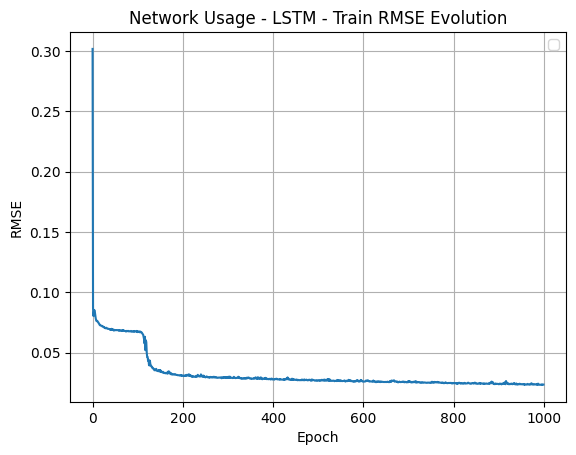

In [16]:
import matplotlib.pyplot as plt

model_name = "LSTM"

plt.plot(train_rmse_history)
plt.title(f"{metric_name} - {model_name} - Train RMSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
#plt.show()
plt.savefig(f"plots/{metric_name} {model_name}.png", dpi=300)